In [13]:
%load_ext autoreload
%autoreload 2

In [14]:
import os,sys
import scanpy as sc 
import pandas as pd
import numpy as np
import milopy
import scipy
import anndata

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set_context('talk')
from matplotlib.pyplot import rc_context

import milopy
import milopy.core as milo

In [77]:
from oor_benchmark.metrics import auprc, FDR_TPR_FPR

In [15]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [16]:
%load_ext rpy2.ipython

In [17]:
%%R
library(tidyverse)

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down


See `submit_oor_design_v2.sh`

In [71]:
outdir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/'
dirs = [x for x in os.listdir(outdir) if x.startswith('qPBMC_500cells_demo_perturb_cell_') and not x.endswith("withOOR") and not x.endswith(".pkl")]

In [72]:
dirs

['qPBMC_500cells_demo_perturb_cell_typememory_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022',
 'qPBMC_500cells_demo_perturb_cell_typeconventional_dendritic_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022',
 'qPBMC_500cells_demo_perturb_cell_typenaive_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022',
 'qPBMC_500cells_demo_perturb_cell_typecentral_memory_CD4_positive_alpha_beta_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022',
 'qPBMC_500cells_demo_perturb_cell_typeplasmablast_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022',
 'qPBMC_500cells_demo_perturb_cell_typeneutrophil_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022',
 'qPBMC_500cells_demo_perturb_cell_typeplatelet_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022',
 'qPBMC_500cells_demo_perturb_cell_typeplasmacytoid_dendritic_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022',
 'qPBMC_500cells_demo_perturb_cell_typenaive_thymus_derived_CD4

In [73]:
meld_nhood_df = pd.DataFrame()
for d in dirs:
    nhood_obs_df = pd.read_csv(outdir + d + '/nhoods_obs.scArches_meld.csv', index_col=0)
    meld_nhood_df = pd.concat([meld_nhood_df, nhood_obs_df])

In [23]:
%%R -i meld_nhood_df
head(meld_nhood_df)

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


   sex tissue ethnicity disease                          assay
1 male  blood   unknown  normal 10x 3' transcription profiling
2 male  blood   unknown  normal 10x 3' transcription profiling
3 male  blood   unknown  normal 10x 3' transcription profiling
4 male  blood   unknown  normal 10x 3' transcription profiling
5 male  blood   unknown  normal 10x 3' transcription profiling
6 male  blood   unknown  normal 10x 3' transcription profiling
  assay_ontology_term_id sample_id  donor_id                 dataset_id
1            EFO:0030003 MH8919227 MH8919227 10_1038_s41591_021_01329_2
2            EFO:0030003 MH8919227 MH8919227 10_1038_s41591_021_01329_2
3            EFO:0030003 MH8919227 MH8919227 10_1038_s41591_021_01329_2
4            EFO:0030003 MH8919227 MH8919227 10_1038_s41591_021_01329_2
5            EFO:0030003 MH8919227 MH8919227 10_1038_s41591_021_01329_2
6            EFO:0030003 MH8919227 MH8919227 10_1038_s41591_021_01329_2
          development_stage                       cell_

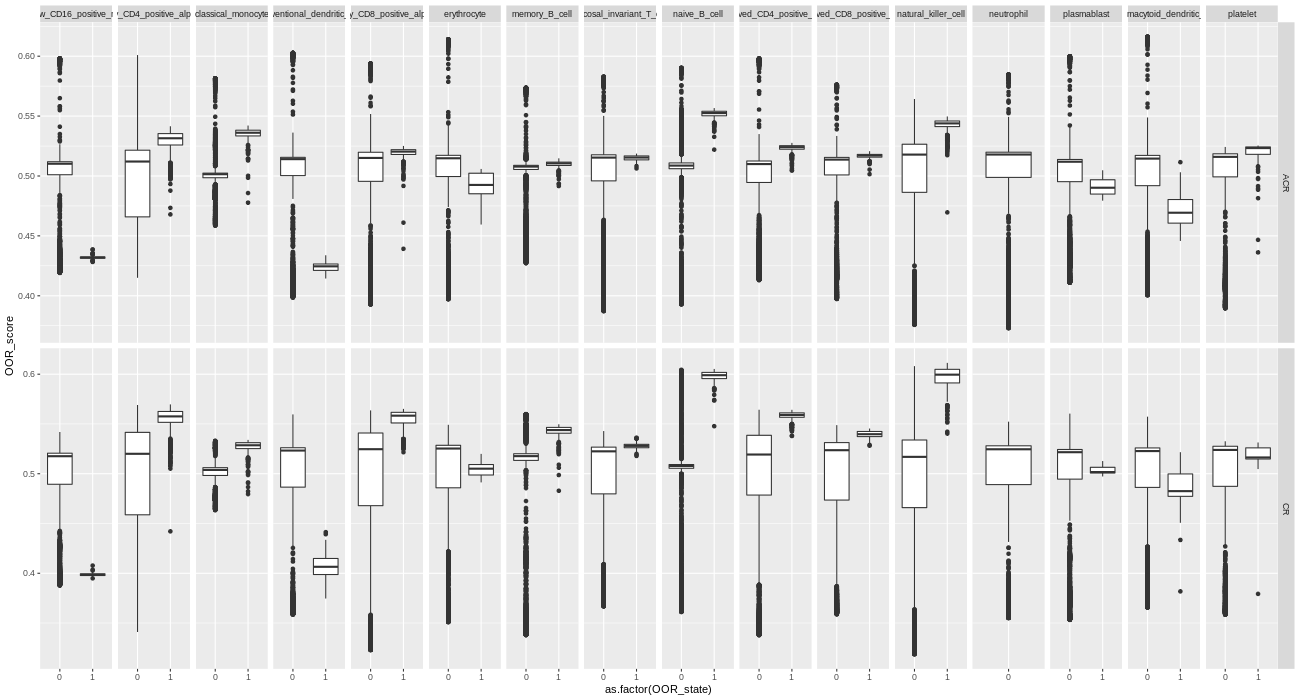

In [29]:
%%R -w 1300 -h 700
meld_nhood_df %>%
ggplot(aes(as.factor(OOR_state), OOR_score)) +
geom_boxplot() +
# geom_jitter() +
facet_grid(design~OOR_state_name, scales='free')

Fix direction:

In [74]:
mean_score = meld_nhood_df.groupby(['OOR_state_name', 'OOR_state'])['OOR_score'].median().reset_index()
mean_score = mean_score.pivot(index='OOR_state_name', columns='OOR_state', values='OOR_score')
switch_prob = mean_score[1] < mean_score[0]
switch_prob = mean_score.index[switch_prob]
meld_nhood_df['OOR_score'] = np.where(meld_nhood_df['OOR_state_name'].isin(switch_prob), 1 - meld_nhood_df['OOR_score'], meld_nhood_df['OOR_score'])

In [75]:
%%R -i meld_nhood_df
head(meld_nhood_df)

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


   sex tissue ethnicity disease                          assay
1 male  blood   unknown  normal 10x 3' transcription profiling
2 male  blood   unknown  normal 10x 3' transcription profiling
3 male  blood   unknown  normal 10x 3' transcription profiling
4 male  blood   unknown  normal 10x 3' transcription profiling
5 male  blood   unknown  normal 10x 3' transcription profiling
6 male  blood   unknown  normal 10x 3' transcription profiling
  assay_ontology_term_id sample_id  donor_id                 dataset_id
1            EFO:0030003 MH8919227 MH8919227 10_1038_s41591_021_01329_2
2            EFO:0030003 MH8919227 MH8919227 10_1038_s41591_021_01329_2
3            EFO:0030003 MH8919227 MH8919227 10_1038_s41591_021_01329_2
4            EFO:0030003 MH8919227 MH8919227 10_1038_s41591_021_01329_2
5            EFO:0030003 MH8919227 MH8919227 10_1038_s41591_021_01329_2
6            EFO:0030003 MH8919227 MH8919227 10_1038_s41591_021_01329_2
          development_stage                       cell_

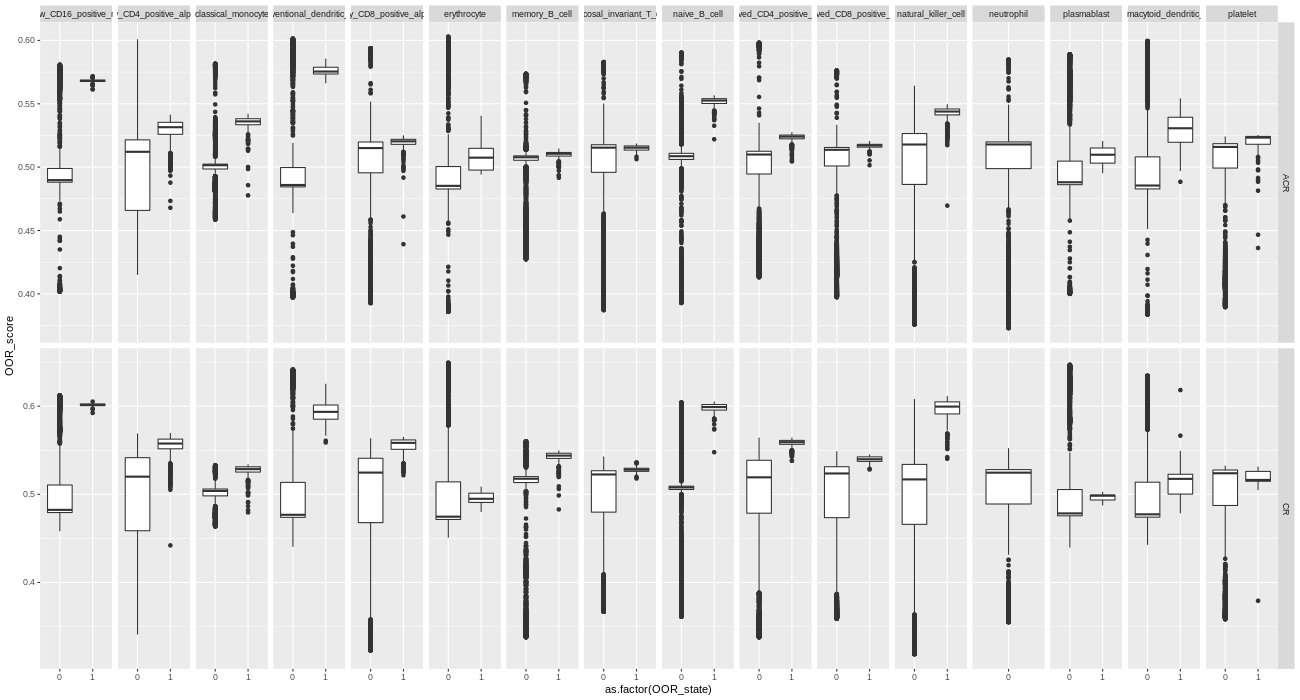

In [76]:
%%R -w 1300 -h 700
meld_nhood_df %>%
ggplot(aes(as.factor(OOR_state), OOR_score)) +
geom_boxplot() +
# geom_jitter() +
facet_grid(design~OOR_state_name, scales='free')

In [119]:
meld_nhood_df[meld_nhood_df['OOR_state_name'] == 'CD14_low_CD16_positive_monocyte']

,sex,tissue,ethnicity,disease,assay,assay_ontology_term_id,sample_id,donor_id,dataset_id,development_stage,...,cell_annotation,Site,is_query,OOR_score,OOR_signif,n_OOR_cells,frac_OOR_cells,OOR_state_group,design,OOR_state_name
10_1038_s41591_021_01329_2-TGGGAAGGTATAGTAG-MH8919227,male,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,MH8919227,MH8919227,10_1038_s41591_021_01329_2,fourth decade human stage,...,natural_killer_cell,MH8,False,0.491047,False,0.0,0.0,0,ACR,CD14_low_CD16_positive_monocyte
10_1038_s41591_021_01329_2-CATGGCGAGACAAGCC-MH8919227,male,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,MH8919227,MH8919227,10_1038_s41591_021_01329_2,fourth decade human stage,...,effector_memory_CD8_positive_alpha_beta_T_cell,MH8,False,0.491083,False,0.0,0.0,0,ACR,CD14_low_CD16_positive_monocyte
10_1038_s41591_021_01329_2-ACATGGTCATCAGTCA-MH8919227,male,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,MH8919227,MH8919227,10_1038_s41591_021_01329_2,fourth decade human stage,...,natural_killer_cell,MH8,False,0.488184,False,0.0,0.0,0,ACR,CD14_low_CD16_positive_monocyte
10_1038_s41591_021_01329_2-AAAGTAGTCCTGCTTG-MH8919227,male,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,MH8919227,MH8919227,10_1038_s41591_021_01329_2,fourth decade human stage,...,natural_killer_cell,MH8,False,0.487657,False,0.0,0.0,0,ACR,CD14_low_CD16_positive_monocyte
10_1038_s41591_021_01329_2-GTGCGGTGTCTCATCC-MH8919227,male,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,MH8919227,MH8919227,10_1038_s41591_021_01329_2,fourth decade human stage,...,central_memory_CD4_positive_alpha_beta_T_cell,MH8,False,0.498534,False,0.0,0.0,0,ACR,CD14_low_CD16_positive_monocyte
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10_1038_s41591_021_01329_2-BGCV04_CTCGAGGAGCTACCGC-1,female,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,BGCV04_CV0911,CV0911,10_1038_s41591_021_01329_2,fifth decade human stage,...,natural_killer_cell,CV0,True,0.486382,False,0.0,0.0,0,CR,CD14_low_CD16_positive_monocyte
10_1038_s41591_021_01329_2-BGCV04_CATGGCGCATAAGACA-1,female,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,BGCV04_CV0911,CV0911,10_1038_s41591_021_01329_2,fifth decade human stage,...,natural_killer_cell,CV0,True,0.486052,False,0.0,0.0,0,CR,CD14_low_CD16_positive_monocyte
10_1038_s41591_021_01329_2-BGCV04_CTGATAGCACTCTGTC-1,female,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,BGCV04_CV0911,CV0911,10_1038_s41591_021_01329_2,fifth decade human stage,...,natural_killer_cell,CV0,True,0.485950,False,0.0,0.0,0,CR,CD14_low_CD16_positive_monocyte
10_1038_s41591_021_01329_2-BGCV04_AACCATGTCAAGGTAA-1,female,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,BGCV04_CV0911,CV0911,10_1038_s41591_021_01329_2,fifth decade human stage,...,natural_killer_cell,CV0,True,0.485728,False,0.0,0.0,0,CR,CD14_low_CD16_positive_monocyte


In [121]:
meld_nhood_df.loc[meld_nhood_df.index[0]]['OOR_state']

10_1038_s41591_021_01329_2-CGGGTCATCCGTTGCT-MH8919227    0
10_1038_s41591_021_01329_2-CGGGTCATCCGTTGCT-MH8919227    0
10_1038_s41591_021_01329_2-CGGGTCATCCGTTGCT-MH8919227    0
10_1038_s41591_021_01329_2-CGGGTCATCCGTTGCT-MH8919227    0
10_1038_s41591_021_01329_2-CGGGTCATCCGTTGCT-MH8919227    0
10_1038_s41591_021_01329_2-CGGGTCATCCGTTGCT-MH8919227    0
10_1038_s41591_021_01329_2-CGGGTCATCCGTTGCT-MH8919227    0
10_1038_s41591_021_01329_2-CGGGTCATCCGTTGCT-MH8919227    0
10_1038_s41591_021_01329_2-CGGGTCATCCGTTGCT-MH8919227    0
10_1038_s41591_021_01329_2-CGGGTCATCCGTTGCT-MH8919227    0
10_1038_s41591_021_01329_2-CGGGTCATCCGTTGCT-MH8919227    0
10_1038_s41591_021_01329_2-CGGGTCATCCGTTGCT-MH8919227    0
10_1038_s41591_021_01329_2-CGGGTCATCCGTTGCT-MH8919227    0
10_1038_s41591_021_01329_2-CGGGTCATCCGTTGCT-MH8919227    0
10_1038_s41591_021_01329_2-CGGGTCATCCGTTGCT-MH8919227    0
10_1038_s41591_021_01329_2-CGGGTCATCCGTTGCT-MH8919227    0
10_1038_s41591_021_01329_2-CGGGTCATCCGTTGCT-MH8919227   

In [88]:
meld_auprc_df = pd.DataFrame()
for ct in meld_nhood_df['OOR_state_name'].unique():
    for d in meld_nhood_df['design'].unique():
        auprc_df = auprc.auprc(meld_nhood_df[(meld_nhood_df['OOR_state_name'] == ct) & (meld_nhood_df['design'] == d)], return_curve=True)
        auprc_df['design'] = d
        auprc_df['OOR_state_name'] = ct
        meld_auprc_df = pd.concat([meld_auprc_df, auprc_df])

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


In [89]:
%%R -i meld_auprc_df
head(meld_auprc_df)

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


  Recall  Precision      AUPRC no_skill_thresh design OOR_state_name
1      1 0.02883640 0.08058341       0.0288364    ACR  memory_B_cell
2      1 0.02883849 0.08058341       0.0288364    ACR  memory_B_cell
3      1 0.02884058 0.08058341       0.0288364    ACR  memory_B_cell
4      1 0.02884267 0.08058341       0.0288364    ACR  memory_B_cell
5      1 0.02884476 0.08058341       0.0288364    ACR  memory_B_cell
6      1 0.02884685 0.08058341       0.0288364    ACR  memory_B_cell


`summarise()` has grouped output by 'OOR_state_name'. You can override using the `.groups` argument.


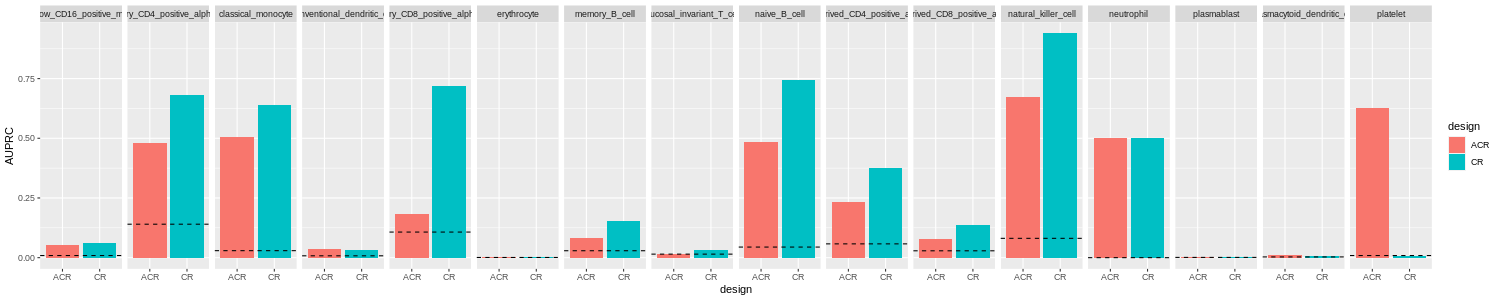

In [98]:
%%R -w 1500 -h 300
meld_auprc_df %>%
ggplot(aes(design, AUPRC, fill=design)) +
geom_col(position='dodge') +
geom_hline(data=. %>% group_by(OOR_state_name, design) %>% summarise(no_skill_thresh=mean(no_skill_thresh)), aes(yintercept=no_skill_thresh), linetype=2) +
facet_wrap(OOR_state_name~., nrow=1)

`summarise()` has grouped output by 'OOR_state_name'. You can override using the `.groups` argument.


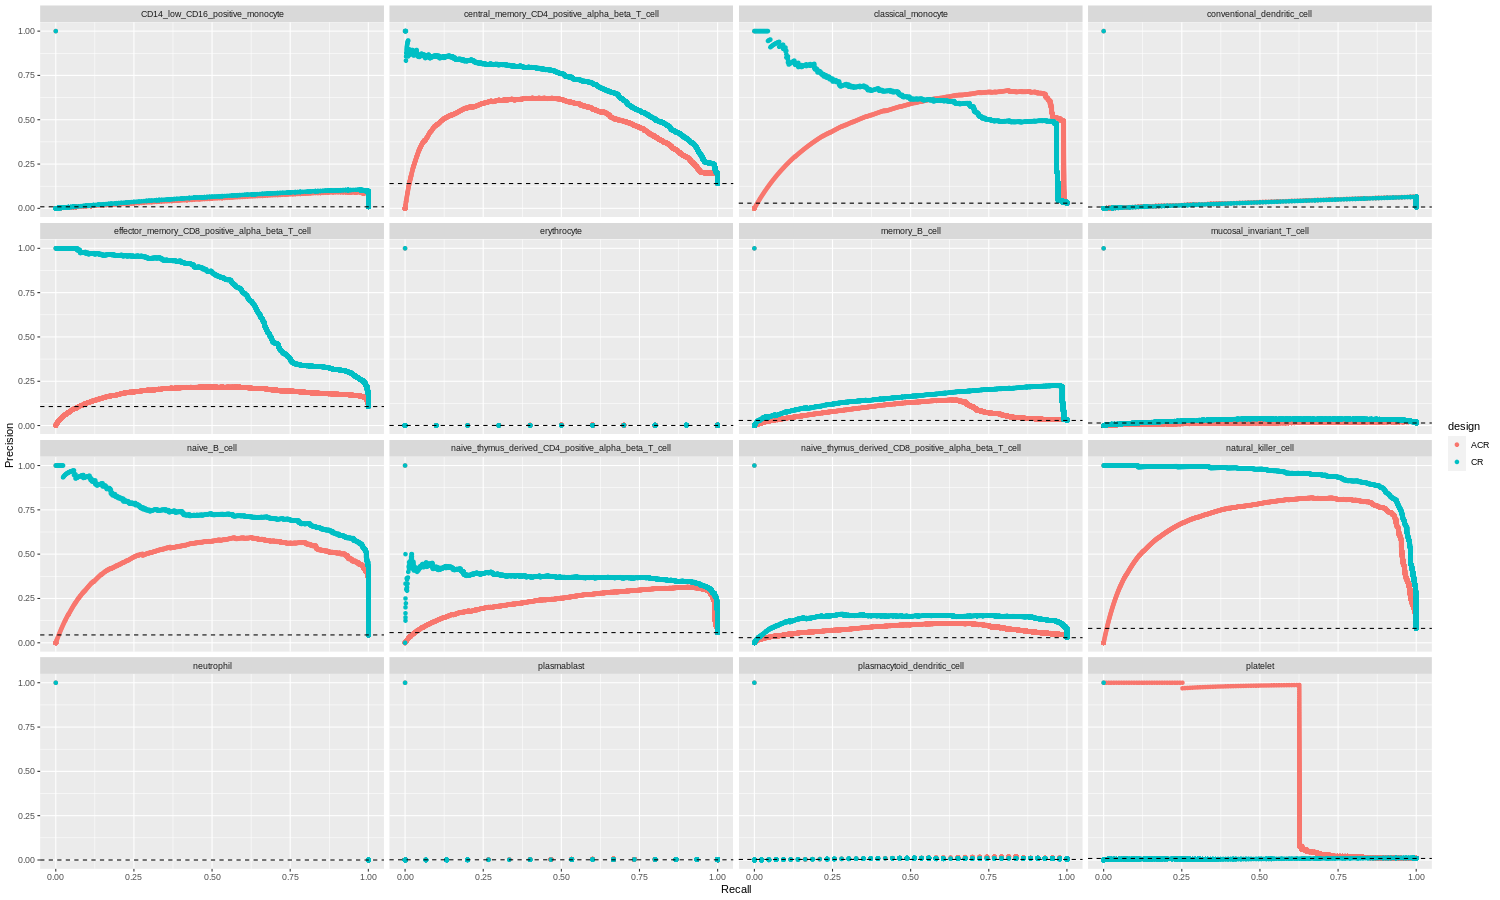

In [101]:
%%R -w 1500 -h 900
meld_auprc_df %>%
ggplot(aes(Recall,Precision, color=design)) +
geom_point() +
geom_hline(data=. %>% group_by(OOR_state_name, design) %>% summarise(no_skill_thresh=mean(no_skill_thresh)), aes(yintercept=no_skill_thresh), linetype=2) +
facet_wrap(OOR_state_name~.)

In [ ]:
from sklearn.metrics import auc, precision_recall_curve

def _auprc(oor_results: Union[AnnData, DataFrame], return_curve: bool = False) -> DataFrame:
    """Calculate area under precision-recall curve for OOR state detection.

    This metric doesn't use the significance/confidence of the OOR state prediction

    Parameters:
    -----------
    oor_results: AnnData or DataFrame
        AnnData object after running method (storing results in oor_results.uns['sample_adata'].var) or DataFrame of results
    return_curve: bool
        Return precision-recall curve (default: False)

    Returns:
    --------
    DataFrame storing AUPRC and no-skill threshold, if return_curve is False
    DataFrame of precision, recall, AUPRC and no-skill threshold, if return_curve is True
    """
    if isinstance(oor_results, AnnData):
        if "OOR_state_group" not in _get_sample_adata(oor_results).var:
            make_OOR_per_group(oor_results)

        out_df = _get_sample_adata(oor_results).var[["OOR_score", "OOR_state_group"]]
    else:
        out_df = oor_results.copy()
    precision, recall, _ = precision_recall_curve(out_df.OOR_state_group, out_df.OOR_score)
    no_skill = sum(out_df.OOR_state_group) / out_df.shape[0]
    AUC = auc(recall, precision)
    if return_curve:
        AUPRC_df = pd.DataFrame(np.vstack([recall, precision]), index=["Recall", "Precision"]).T
        AUPRC_df["AUPRC"] = AUC
        AUPRC_df["no_skill_thresh"] = no_skill
    else:
        AUPRC_df = pd.DataFrame(index=["AUPRC", "no_skill_thresh"]).T
        AUPRC_df.loc[0, "AUPRC"] = AUC
        AUPRC_df.loc[0, "no_skill_thresh"] = no_skill
    return AUPRC_df

In [32]:
auprc.auprc(acr_adata)

,AUPRC,no_skill_thresh
0,0.076857,0.028777


In [19]:
adata.uns['sample_adata'].var

,sex,tissue,ethnicity,disease,assay,assay_ontology_term_id,sample_id,donor_id,dataset_id,development_stage,...,is_train,is_test,is_ctrl,dataset_group,OOR_state,cell_annotation,Site,is_query,OOR_score,OOR_signif
10_1038_s41591_021_01329_2-BGCV01_GACCTGGGTAAGCACG-1,male,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,BGCV01_CV0902,CV0902,10_1038_s41591_021_01329_2,sixth decade human stage,...,0,0,1,ctrl,0,natural_killer_cell,CV0,False,0.523447,False
10_1038_s41591_021_01329_2-TTGGAACCATGGTCTA-MH8919178,male,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,MH8919178,MH8919178,10_1038_s41591_021_01329_2,sixth decade human stage,...,0,0,1,ctrl,0,classical_monocyte,MH8,False,0.384673,False
10_1038_s41591_021_01329_2-AGGCCGTTCGCTTAGA-MH8919178,male,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,MH8919178,MH8919178,10_1038_s41591_021_01329_2,sixth decade human stage,...,0,0,1,ctrl,0,memory_B_cell,MH8,False,0.471647,False
10_1038_s41591_021_01329_2-AAGACCTGTTTGACAC-MH8919178,male,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,MH8919178,MH8919178,10_1038_s41591_021_01329_2,sixth decade human stage,...,0,0,1,ctrl,0,memory_B_cell,MH8,False,0.474263,False
10_1038_s41591_021_01329_2-TAGTTGGCATAACCTG-MH8919178,male,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,MH8919178,MH8919178,10_1038_s41591_021_01329_2,sixth decade human stage,...,0,0,1,ctrl,0,central_memory_CD4_positive_alpha_beta_T_cell,MH8,False,0.531272,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10_1038_s41591_021_01329_2-BGCV04_CAAGTTGGTGCTAGCC-1,female,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,BGCV04_CV0911,CV0911,10_1038_s41591_021_01329_2,fifth decade human stage,...,0,1,0,query,0,naive_thymus_derived_CD4_positive_alpha_beta_T...,CV0,True,0.536789,False
10_1038_s41591_021_01329_2-BGCV04_CTTTGCGAGTGCAAGC-1,female,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,BGCV04_CV0911,CV0911,10_1038_s41591_021_01329_2,fifth decade human stage,...,0,1,0,query,0,natural_killer_cell,CV0,True,0.520313,False
10_1038_s41591_021_01329_2-BGCV04_ATCCGAAGTTCCGTCT-1,female,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,BGCV04_CV0911,CV0911,10_1038_s41591_021_01329_2,fifth decade human stage,...,0,1,0,query,0,natural_killer_cell,CV0,True,0.520036,False
10_1038_s41591_021_01329_2-BGCV04_GCAATCAAGCGTAATA-1,female,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,BGCV04_CV0911,CV0911,10_1038_s41591_021_01329_2,fifth decade human stage,...,0,1,0,query,0,memory_B_cell,CV0,True,0.474481,False


In [122]:
def read_oor_design_output(simdir, ref_design, embedding_method, diff_method, population_obs):
    perturb_pop = simdir.split(population_obs)[1].split('_queryBatch')[0]
    print(f'Reading {perturb_pop}\n')
    h5ad_file = simdir + f'/{ref_design}_design.{embedding_method}_{diff_method}.h5ad'
    if diff_method == 'milo':
        try:
            adata = milopy.utils.read_milo_adata(
                h5ad_file, backed=True)
        except:
            print(f'skipping {ref_design} design')
            return(None)
    else:
        try:
            adata = sc.read_h5ad(h5ad_file, backed=True)
        except:
            print(f'skipping {ref_design} design')
            return(None)
    adata.obs['OOR_state_name'] = perturb_pop
    return(adata)

In [190]:
adata_design = acr_adata
query_group='query'
reference_group='ctrl'
query_samples = adata_design.obs["sample_id"][adata_design.obs["dataset_group"] == query_group].unique().tolist()
reference_samples = (
    adata_design.obs["sample_id"][adata_design.obs["dataset_group"] == reference_group].unique().tolist()
)

In [278]:
import scipy.stats
def _run_wilcoxon(example_acr, OOR_state):
    query_densities = example_acr[(example_acr['OOR_state'] == OOR_state) & (example_acr['dataset_group'] == 'query')]['sample_density'].values
    ctrl_densities = example_acr[(example_acr['OOR_state'] == OOR_state) & (example_acr['dataset_group'] == 'ctrl')]['sample_density'].values
    return(scipy.stats.ranksums(query_densities, ctrl_densities))

def _run_ttest(example_acr, OOR_state):
    query_densities = example_acr[(example_acr['OOR_state'] == OOR_state) & (example_acr['dataset_group'] == 'query')]['sample_density'].values
    ctrl_densities = example_acr[(example_acr['OOR_state'] == OOR_state) & (example_acr['dataset_group'] == 'ctrl')]['sample_density'].values
    return(scipy.stats.ttest_ind(query_densities, ctrl_densities))

In [336]:
def _get_example_densities(adata_design, sample_OOR, sample_InR):
    df1 = adata_design[sample_OOR].obsm["sample_densities"].melt(var_name='sample_id', value_name='sample_density')
    df1['OOR_state'] = 1
    df1['dataset_group'] = np.where(df1['sample_id'].isin(query_samples), 'query', 'ctrl')

    df0 = adata_design[sample_InR].obsm["sample_densities"].melt(var_name='sample_id', value_name='sample_density')
    df0['OOR_state'] = 0
    df0['dataset_group'] = np.where(df0['sample_id'].isin(query_samples), 'query', 'ctrl')

    df = pd.concat([df0, df1])
    return(df)

sample_OOR = np.random.choice(acr_adata.obs_names[acr_adata.obs['OOR_state'] == 1], size=1, replace=False)
sample_InR = np.random.choice(acr_adata.obs_names[acr_adata.obs['OOR_state'] == 0], size=1, replace=False)

example_acr = _get_example_densities(acr_adata, sample_OOR, sample_InR)
example_acr['design'] = 'ACR'
example_cr = _get_example_densities(cr_adata, sample_OOR, sample_InR)
example_cr['design'] = 'CR'
df = pd.concat([example_acr, example_cr])

In [337]:
%%R -i df
head(df)

      sample_id sample_density OOR_state dataset_group design
1 BGCV01_CV0902   6.941661e-05         0          ctrl    ACR
2 BGCV01_CV0904   8.716548e-05         0         query    ACR
3 BGCV02_CV0902   8.269804e-05         0          ctrl    ACR
4 BGCV04_CV0911   8.160811e-05         0         query    ACR
5 BGCV05_CV0929   7.245277e-05         0          ctrl    ACR
6 BGCV08_CV0915   8.098880e-05         0          ctrl    ACR


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


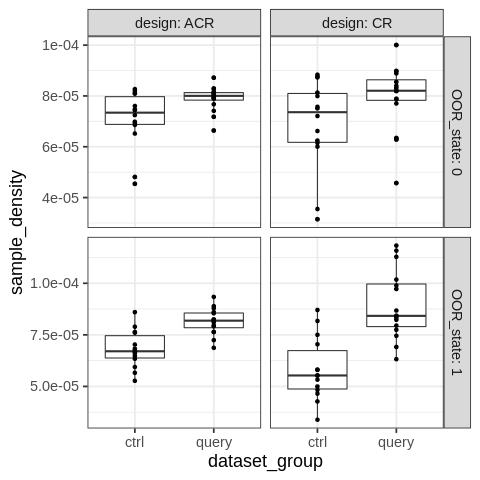

In [338]:
%%R
df %>%
ggplot(aes(dataset_group,sample_density)) +
geom_boxplot() +
geom_point(width=0.1) +
theme_bw(base_size=18) +
facet_grid(OOR_state~design, labeller='label_both', scales='free_y')

In [339]:
example_cr.groupby(['OOR_state', 'dataset_group']).mean()

/tmp/ipykernel_4407/2343792231.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  example_cr.groupby(['OOR_state', 'dataset_group']).mean()


sample_density
OOR_state dataset_group                
0         ctrl                 0.000069
          query                0.000080
1         ctrl                 0.000058
          query                0.000089

In [340]:
example_acr.groupby(['OOR_state', 'dataset_group']).mean()

/tmp/ipykernel_4407/4160328046.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  example_acr.groupby(['OOR_state', 'dataset_group']).mean()


sample_density
OOR_state dataset_group                
0         ctrl                 0.000071
          query                0.000079
1         ctrl                 0.000068
          query                0.000081

In [341]:
def _get_meld(example_cr, OOR_state):
    mean_density = example_cr.groupby(['OOR_state', 'dataset_group']).mean().reset_index()
    probs = normalize(mean_density[mean_density['OOR_state'] == OOR_state]['sample_density'].values.reshape(1,-1), norm='l1')
    return(probs)

In [342]:
print(_get_meld(example_cr, 0))
print(_get_meld(example_cr, 1))

[[0.46395871 0.53604129]]
[[0.39477835 0.60522165]]


/tmp/ipykernel_4407/100487559.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_density = example_cr.groupby(['OOR_state', 'dataset_group']).mean().reset_index()
/tmp/ipykernel_4407/100487559.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_density = example_cr.groupby(['OOR_state', 'dataset_group']).mean().reset_index()


In [343]:
print(_get_meld(example_acr, 0))
print(_get_meld(example_acr, 1))

[[0.47257977 0.52742023]]
[[0.4551933 0.5448067]]


/tmp/ipykernel_4407/100487559.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_density = example_cr.groupby(['OOR_state', 'dataset_group']).mean().reset_index()
/tmp/ipykernel_4407/100487559.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_density = example_cr.groupby(['OOR_state', 'dataset_group']).mean().reset_index()


In [344]:
print(_run_wilcoxon(example_acr, 0))
print(_run_wilcoxon(example_acr, 1))

RanksumsResult(statistic=2.120098032686877, pvalue=0.03399777884079311)
RanksumsResult(statistic=3.74134946944743, pvalue=0.00018303479550820938)


In [345]:
print(_run_ttest(example_acr, 0))
print(_run_ttest(example_acr, 1))

Ttest_indResult(statistic=2.5990695443160696, pvalue=0.01474800571404792)
Ttest_indResult(statistic=4.78673535604674, pvalue=4.968528925947287e-05)


In [346]:
print(_run_wilcoxon(example_cr, 0))
print(_run_wilcoxon(example_cr, 1))

RanksumsResult(statistic=2.036956933365823, pvalue=0.041654357952089036)
RanksumsResult(statistic=3.824490568768484, pvalue=0.0001310427619889688)


In [347]:
print(_run_ttest(example_cr, 0))
print(_run_ttest(example_cr, 1))

Ttest_indResult(statistic=1.9004088405369761, pvalue=0.06772099088723575)
Ttest_indResult(statistic=5.33667493396452, pvalue=1.1054918695695874e-05)


In [370]:
pd.concat([acr_adata.obs, pd.DataFrame(np.vstack([np.array(pvals),np.array(statistics)]).T, columns=['wilcox_pval', 'wilcox_stat'])], 1)

/tmp/ipykernel_4407/4225038744.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  pd.concat([acr_adata.obs, pd.DataFrame(np.vstack([np.array(pvals),np.array(statistics)]).T, columns=['wilcox_pval', 'wilcox_stat'])], 1)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = repr(obj)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/IPython/core/formatters.py:343: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return method()


,sex,tissue,ethnicity,disease,assay,assay_ontology_term_id,sample_id,donor_id,dataset_id,development_stage,...,is_test,is_ctrl,dataset_group,OOR_state,cell_annotation,Site,is_query,OOR_state_name,wilcox_pval,wilcox_stat
10_1038_s41591_021_01329_2-BGCV02_TGCGGGTTCAGCTCTC-1,male,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,BGCV02_CV0902,CV0902,10_1038_s41591_021_01329_2,sixth decade human stage,...,0.0,1.0,ctrl,0.0,effector_memory_CD8_positive_alpha_beta_T_cell,CV0,False,natural_killer_cell,NaN,NaN
10_1038_s41591_021_01329_2-BGCV02_GCAGCCAGTTGCGTTA-1,male,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,BGCV02_CV0902,CV0902,10_1038_s41591_021_01329_2,sixth decade human stage,...,0.0,1.0,ctrl,0.0,effector_memory_CD8_positive_alpha_beta_T_cell,CV0,False,natural_killer_cell,NaN,NaN
10_1038_s41591_021_01329_2-BGCV02_TCATTACGTCAGGACA-1,male,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,BGCV02_CV0902,CV0902,10_1038_s41591_021_01329_2,sixth decade human stage,...,0.0,1.0,ctrl,0.0,naive_B_cell,CV0,False,natural_killer_cell,NaN,NaN
10_1038_s41591_021_01329_2-BGCV02_AAGGTTCGTTGTGGCC-1,male,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,BGCV02_CV0902,CV0902,10_1038_s41591_021_01329_2,sixth decade human stage,...,0.0,1.0,ctrl,0.0,central_memory_CD4_positive_alpha_beta_T_cell,CV0,False,natural_killer_cell,NaN,NaN
10_1038_s41591_021_01329_2-BGCV02_CCCAATCAGGCCGAAT-1,male,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,BGCV02_CV0902,CV0902,10_1038_s41591_021_01329_2,sixth decade human stage,...,0.0,1.0,ctrl,0.0,naive_thymus_derived_CD8_positive_alpha_beta_T...,CV0,False,natural_killer_cell,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13171,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002762,2.993080
13172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.405741,-0.831411
13173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.080817,1.745963
13174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.339010,-0.956123


In [401]:
def _run_stats_comparison(acr_adata, cr_adata):
    # Get sample ids
    adata_design = acr_adata
    query_group='query'
    reference_group='ctrl'
    query_samples = adata_design.obs["sample_id"][adata_design.obs["dataset_group"] == query_group].unique().tolist()
    reference_samples = (
        adata_design.obs["sample_id"][adata_design.obs["dataset_group"] == reference_group].unique().tolist()
    )

    pvals = []
    statistics = []
    for i,c in acr_adata.obsm['sample_densities'].iterrows():
        statistic, pval = scipy.stats.ranksums(c[query_samples].values, c[reference_samples].values)
        pvals.append(pval)
        statistics.append(statistic)

    wilcox_df = pd.DataFrame(np.vstack([np.array(pvals),np.array(statistics)]).T, columns=['wilcox_pval', 'wilcox_stat'])
    wilcox_df.index = acr_adata.obs_names
    acr_adata.obs = pd.concat([acr_adata.obs, wilcox_df], 1)

    pvals = []
    statistics = []
    for i,c in cr_adata.obsm['sample_densities'].iterrows():
        statistic, pval = scipy.stats.ranksums(c[query_samples].values, c[reference_samples].values)
        pvals.append(pval)
        statistics.append(statistic)

    wilcox_df = pd.DataFrame(np.vstack([np.array(pvals),np.array(statistics)]).T, columns=['wilcox_pval', 'wilcox_stat'])
    wilcox_df.index = cr_adata.obs_names
    cr_adata.obs = pd.concat([cr_adata.obs, wilcox_df], 1)

    acr_adata.obs['meld_probability'] = acr_adata.uns['sample_adata'].var['OOR_score']
    cr_adata.obs['meld_probability'] = cr_adata.uns['sample_adata'].var['OOR_score']

    acr_adata.uns['sample_adata'].var['OOR_score'] = acr_adata.obs['wilcox_stat'].copy()
    cr_adata.uns['sample_adata'].var['OOR_score'] = cr_adata.obs['wilcox_stat'].copy()
    acr_auprc_df = auprc.auprc(acr_adata, return_curve=True)
    acr_auprc_df['design'] = 'ACR'
    acr_auprc_df['stat'] = 'wilcox'
    cr_auprc_df = auprc.auprc(cr_adata, return_curve=True)
    cr_auprc_df['design'] = 'CR'
    cr_auprc_df['stat'] = 'wilcox'
    auprc_df_wilcox = pd.concat([acr_auprc_df,cr_auprc_df])

    acr_adata.uns['sample_adata'].var['OOR_score'] = acr_adata.obs['meld_probability'].copy()
    cr_adata.uns['sample_adata'].var['OOR_score'] = cr_adata.obs['meld_probability'].copy()
    acr_auprc_df = auprc.auprc(acr_adata, return_curve=True)
    acr_auprc_df['design'] = 'ACR'
    acr_auprc_df['stat'] = 'prob'
    cr_auprc_df = auprc.auprc(cr_adata, return_curve=True)
    cr_auprc_df['design'] = 'CR'
    cr_auprc_df['stat'] = 'prob'
    auprc_df_prob = pd.concat([acr_auprc_df,cr_auprc_df])

    AUPRC_compare = pd.concat([auprc_df_prob, auprc_df_wilcox])
    return(AUPRC_compare)

In [396]:
%%R -i AUPRC_compare
head(AUPRC_compare)

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


  Recall  Precision     AUPRC no_skill_thresh design stat
1      1 0.08098057 0.6734793      0.08098057    ACR prob
2      1 0.08098672 0.6734793      0.08098057    ACR prob
3      1 0.08099286 0.6734793      0.08098057    ACR prob
4      1 0.08099901 0.6734793      0.08098057    ACR prob
5      1 0.08100516 0.6734793      0.08098057    ACR prob
6      1 0.08101131 0.6734793      0.08098057    ACR prob


`summarise()` has grouped output by 'stat'. You can override using the `.groups` argument.


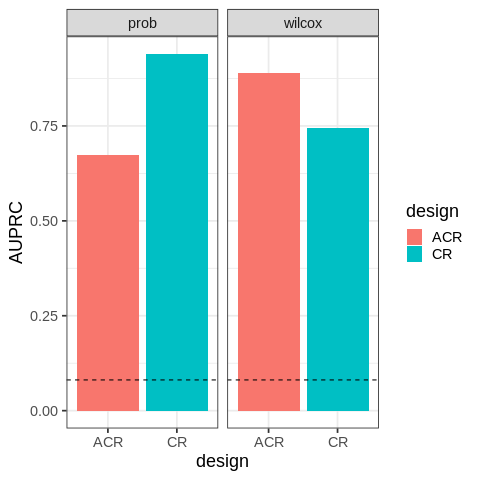

In [400]:
%%R 
AUPRC_compare %>%
ggplot(aes(design, AUPRC, fill=design)) +
geom_col(position='dodge') +
geom_hline(data=. %>% group_by(stat, design) %>% summarise(no_skill_thresh=mean(no_skill_thresh)), aes(yintercept=no_skill_thresh), linetype=2) +
facet_wrap(stat~., nrow=1) +
theme_bw(base_size=18)

In [403]:
stat_comparison_result = pd.DataFrame()
for d in dirs:
    print(d)
    simdir = outdir + d
    acr_adata = read_oor_design_output(simdir, 'ACR', embedding_method='scArches', diff_method='meld', population_obs = 'cell_type')
    cr_adata = read_oor_design_output(simdir, 'CR', embedding_method='scArches', diff_method='meld', population_obs = 'cell_type')
    AUPRC_df = _run_stats_comparison(acr_adata=acr_adata, cr_adata=cr_adata)
    AUPRC_df['OOR_state_name'] = acr_adata.obs['OOR_state_name'].unique()[0]
    stat_comparison_result = pd.concat([stat_comparison_result, AUPRC_df])

qPBMC_500cells_demo_perturb_cell_typememory_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading memory_B_cell

Reading memory_B_cell



/tmp/ipykernel_4407/3965191629.py:20: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  acr_adata.obs = pd.concat([acr_adata.obs, wilcox_df], 1)
/tmp/ipykernel_4407/3965191629.py:31: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  cr_adata.obs = pd.concat([cr_adata.obs, wilcox_df], 1)


qPBMC_500cells_demo_perturb_cell_typeconventional_dendritic_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading conventional_dendritic_cell

Reading conventional_dendritic_cell



/tmp/ipykernel_4407/3965191629.py:20: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  acr_adata.obs = pd.concat([acr_adata.obs, wilcox_df], 1)
/tmp/ipykernel_4407/3965191629.py:31: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  cr_adata.obs = pd.concat([cr_adata.obs, wilcox_df], 1)


qPBMC_500cells_demo_perturb_cell_typenaive_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading naive_B_cell

Reading naive_B_cell



/tmp/ipykernel_4407/3965191629.py:20: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  acr_adata.obs = pd.concat([acr_adata.obs, wilcox_df], 1)
/tmp/ipykernel_4407/3965191629.py:31: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  cr_adata.obs = pd.concat([cr_adata.obs, wilcox_df], 1)


qPBMC_500cells_demo_perturb_cell_typecentral_memory_CD4_positive_alpha_beta_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading central_memory_CD4_positive_alpha_beta_T_cell

Reading central_memory_CD4_positive_alpha_beta_T_cell



/tmp/ipykernel_4407/3965191629.py:20: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  acr_adata.obs = pd.concat([acr_adata.obs, wilcox_df], 1)
/tmp/ipykernel_4407/3965191629.py:31: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  cr_adata.obs = pd.concat([cr_adata.obs, wilcox_df], 1)


qPBMC_500cells_demo_perturb_cell_typeplasmablast_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading plasmablast

Reading plasmablast



/tmp/ipykernel_4407/3965191629.py:20: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  acr_adata.obs = pd.concat([acr_adata.obs, wilcox_df], 1)
/tmp/ipykernel_4407/3965191629.py:31: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  cr_adata.obs = pd.concat([cr_adata.obs, wilcox_df], 1)


qPBMC_500cells_demo_perturb_cell_typeneutrophil_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading neutrophil

Reading neutrophil



/tmp/ipykernel_4407/3965191629.py:20: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  acr_adata.obs = pd.concat([acr_adata.obs, wilcox_df], 1)
/tmp/ipykernel_4407/3965191629.py:31: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  cr_adata.obs = pd.concat([cr_adata.obs, wilcox_df], 1)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_t

qPBMC_500cells_demo_perturb_cell_typeplatelet_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading platelet

Reading platelet



/tmp/ipykernel_4407/3965191629.py:20: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  acr_adata.obs = pd.concat([acr_adata.obs, wilcox_df], 1)
/tmp/ipykernel_4407/3965191629.py:31: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  cr_adata.obs = pd.concat([cr_adata.obs, wilcox_df], 1)


qPBMC_500cells_demo_perturb_cell_typeplasmacytoid_dendritic_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading plasmacytoid_dendritic_cell

Reading plasmacytoid_dendritic_cell



/tmp/ipykernel_4407/3965191629.py:20: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  acr_adata.obs = pd.concat([acr_adata.obs, wilcox_df], 1)
/tmp/ipykernel_4407/3965191629.py:31: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  cr_adata.obs = pd.concat([cr_adata.obs, wilcox_df], 1)


qPBMC_500cells_demo_perturb_cell_typenaive_thymus_derived_CD4_positive_alpha_beta_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading naive_thymus_derived_CD4_positive_alpha_beta_T_cell

Reading naive_thymus_derived_CD4_positive_alpha_beta_T_cell



/tmp/ipykernel_4407/3965191629.py:20: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  acr_adata.obs = pd.concat([acr_adata.obs, wilcox_df], 1)
/tmp/ipykernel_4407/3965191629.py:31: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  cr_adata.obs = pd.concat([cr_adata.obs, wilcox_df], 1)


qPBMC_500cells_demo_perturb_cell_typeclassical_monocyte_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading classical_monocyte

Reading classical_monocyte



/tmp/ipykernel_4407/3965191629.py:20: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  acr_adata.obs = pd.concat([acr_adata.obs, wilcox_df], 1)
/tmp/ipykernel_4407/3965191629.py:31: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  cr_adata.obs = pd.concat([cr_adata.obs, wilcox_df], 1)


qPBMC_500cells_demo_perturb_cell_typeerythrocyte_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading erythrocyte

Reading erythrocyte



/tmp/ipykernel_4407/3965191629.py:20: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  acr_adata.obs = pd.concat([acr_adata.obs, wilcox_df], 1)
/tmp/ipykernel_4407/3965191629.py:31: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  cr_adata.obs = pd.concat([cr_adata.obs, wilcox_df], 1)


qPBMC_500cells_demo_perturb_cell_typenaive_thymus_derived_CD8_positive_alpha_beta_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading naive_thymus_derived_CD8_positive_alpha_beta_T_cell

Reading naive_thymus_derived_CD8_positive_alpha_beta_T_cell



/tmp/ipykernel_4407/3965191629.py:20: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  acr_adata.obs = pd.concat([acr_adata.obs, wilcox_df], 1)
/tmp/ipykernel_4407/3965191629.py:31: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  cr_adata.obs = pd.concat([cr_adata.obs, wilcox_df], 1)


qPBMC_500cells_demo_perturb_cell_typenatural_killer_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading natural_killer_cell

Reading natural_killer_cell



/tmp/ipykernel_4407/3965191629.py:20: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  acr_adata.obs = pd.concat([acr_adata.obs, wilcox_df], 1)
/tmp/ipykernel_4407/3965191629.py:31: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  cr_adata.obs = pd.concat([cr_adata.obs, wilcox_df], 1)


qPBMC_500cells_demo_perturb_cell_typeeffector_memory_CD8_positive_alpha_beta_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading effector_memory_CD8_positive_alpha_beta_T_cell

Reading effector_memory_CD8_positive_alpha_beta_T_cell



/tmp/ipykernel_4407/3965191629.py:20: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  acr_adata.obs = pd.concat([acr_adata.obs, wilcox_df], 1)
/tmp/ipykernel_4407/3965191629.py:31: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  cr_adata.obs = pd.concat([cr_adata.obs, wilcox_df], 1)


qPBMC_500cells_demo_perturb_cell_typemucosal_invariant_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading mucosal_invariant_T_cell

Reading mucosal_invariant_T_cell



/tmp/ipykernel_4407/3965191629.py:20: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  acr_adata.obs = pd.concat([acr_adata.obs, wilcox_df], 1)
/tmp/ipykernel_4407/3965191629.py:31: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  cr_adata.obs = pd.concat([cr_adata.obs, wilcox_df], 1)


qPBMC_500cells_demo_perturb_cell_typeCD14_low_CD16_positive_monocyte_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading CD14_low_CD16_positive_monocyte

Reading CD14_low_CD16_positive_monocyte



/tmp/ipykernel_4407/3965191629.py:20: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  acr_adata.obs = pd.concat([acr_adata.obs, wilcox_df], 1)
/tmp/ipykernel_4407/3965191629.py:31: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  cr_adata.obs = pd.concat([cr_adata.obs, wilcox_df], 1)


In [407]:
stat_comparison_result

,Recall,Precision,AUPRC,no_skill_thresh,design,stat,OOR_state_name
0,1.0,0.028836,0.080583,0.028836,ACR,prob,memory_B_cell
1,1.0,0.028838,0.080583,0.028836,ACR,prob,memory_B_cell
2,1.0,0.028841,0.080583,0.028836,ACR,prob,memory_B_cell
3,1.0,0.028843,0.080583,0.028836,ACR,prob,memory_B_cell
4,1.0,0.028845,0.080583,0.028836,ACR,prob,memory_B_cell
...,...,...,...,...,...,...,...
88,0.0,0.000000,0.004804,0.008896,CR,wilcox,CD14_low_CD16_positive_monocyte
89,0.0,0.000000,0.004804,0.008896,CR,wilcox,CD14_low_CD16_positive_monocyte
90,0.0,0.000000,0.004804,0.008896,CR,wilcox,CD14_low_CD16_positive_monocyte
91,0.0,0.000000,0.004804,0.008896,CR,wilcox,CD14_low_CD16_positive_monocyte


In [408]:
%%R -i stat_comparison_result
head(stat_comparison_result)

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


  Recall  Precision      AUPRC no_skill_thresh design stat OOR_state_name
1      1 0.02883640 0.08058341       0.0288364    ACR prob  memory_B_cell
2      1 0.02883849 0.08058341       0.0288364    ACR prob  memory_B_cell
3      1 0.02884058 0.08058341       0.0288364    ACR prob  memory_B_cell
4      1 0.02884267 0.08058341       0.0288364    ACR prob  memory_B_cell
5      1 0.02884476 0.08058341       0.0288364    ACR prob  memory_B_cell
6      1 0.02884685 0.08058341       0.0288364    ACR prob  memory_B_cell


`summarise()` has grouped output by 'stat'. You can override using the `.groups` argument.


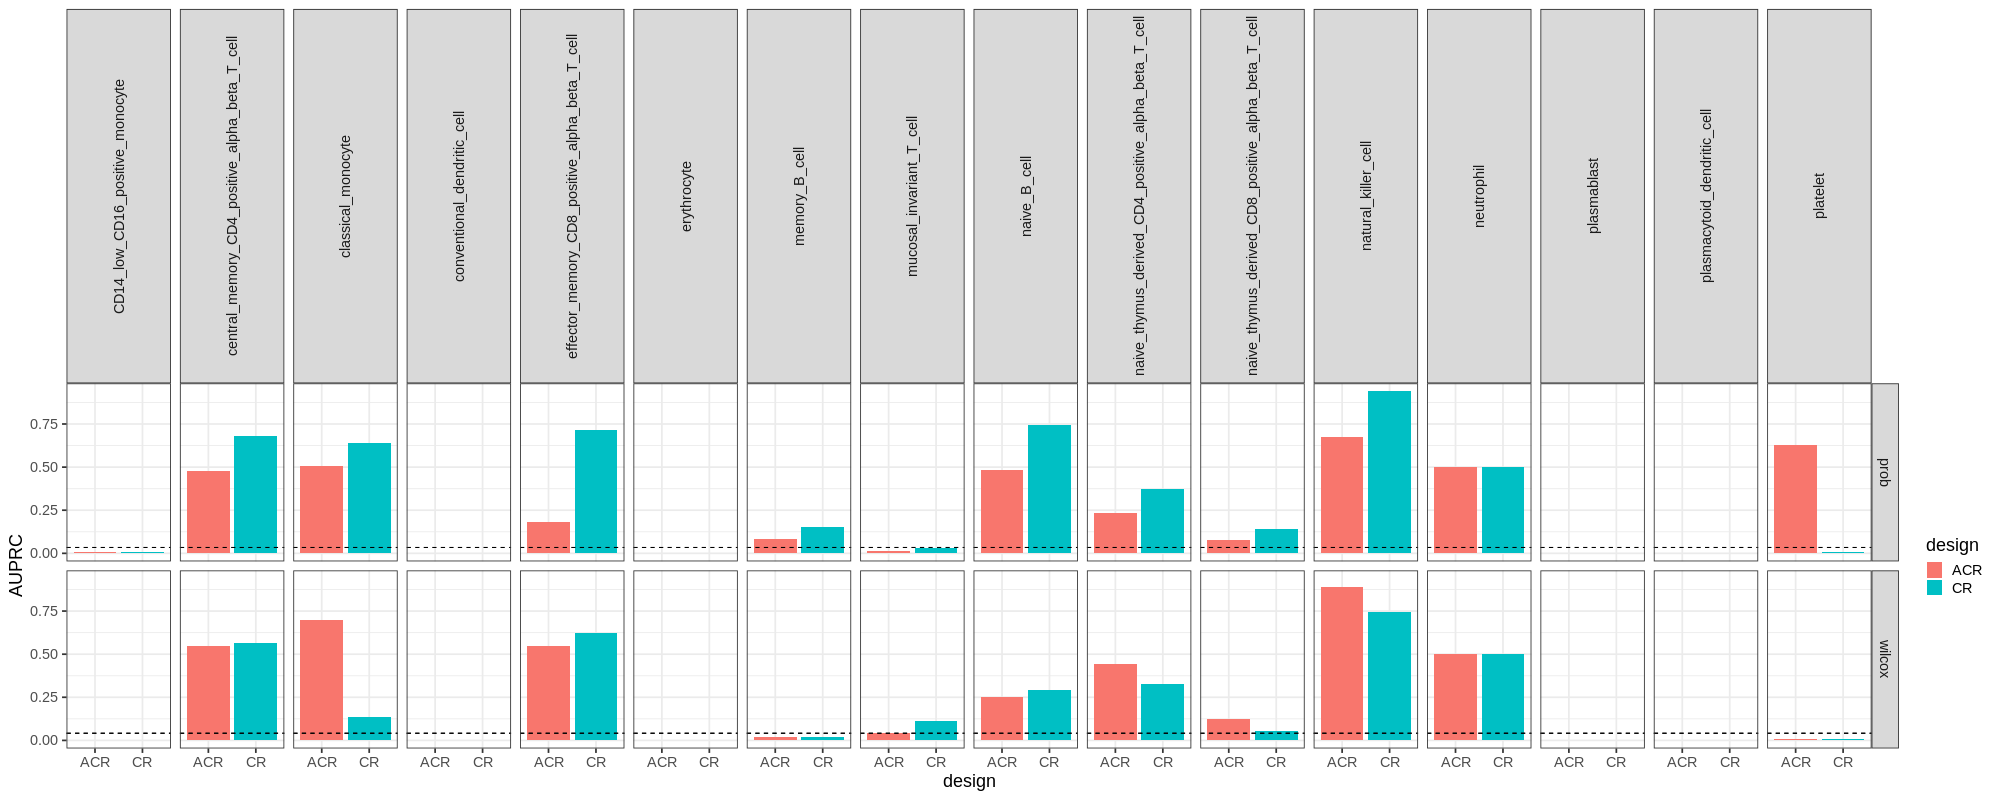

In [416]:
%%R -h 800 -w 2000
stat_comparison_result %>%
ggplot(aes(design, AUPRC, fill=design)) +
geom_col(position='dodge') +
geom_hline(data=. %>% group_by(stat, design) %>% summarise(no_skill_thresh=mean(no_skill_thresh)), aes(yintercept=no_skill_thresh), linetype=2) +
facet_grid(stat~OOR_state_name) +
theme_bw(base_size=18) +
theme(strip.text.x=element_text(angle=90))

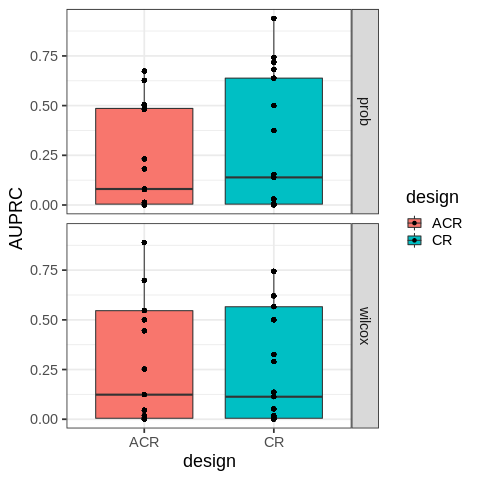

In [417]:
%%R 
stat_comparison_result %>%
ggplot(aes(design, AUPRC, fill=design)) +
geom_boxplot() +
geom_point() +
facet_grid(stat~.) +
theme_bw(base_size=18) +
theme(strip.text.x=element_text(angle=90))